In [ ]:
import pandas as pd
from google.colab import files
file_path = 'cleaned_electricity_data.csv'
data = pd.read_csv(file_path)

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Exploratory Data Analysis (EDA)

In [ ]:
data.head()

,CONS_NO,FLAG,2014/1/1,2014/1/10,2014/1/11,2014/1/12,2014/1/13,2014/1/14,2014/1/15,2014/1/16,...,2016/9/29,2016/9/3,2016/9/30,2016/9/4,2016/9/5,2016/9/6,2016/9/7,2016/9/8,2016/9/9,total_consumption
0,0387DD8A07E07FDA6271170F86AD9151,1,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,9.96,16.92,7.60,27.22,18.05,26.47,18.75,17.84,14.92,8213.92
1,01D6177B5D4FFE0CABA9EF17DAFC2B84,1,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,4B75AC4F2D8434CFF62DB64D0BB43103,1,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2569.64
3,B32AC8CC6D5D805AC053557AB05F5343,1,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,9.99,11.78,18.59,26.80,18.57,14.59,12.82,19.37,15.92,6896.89
4,EDFC78B07BA2908B3395C4EB2304665E,1,2.9,3.42,3.81,4.58,3.56,4.25,3.86,3.53,...,10.37,15.32,13.51,12.23,14.68,16.35,18.14,18.41,17.31,8497.23


# Preprocessing

In [ ]:
X = data.drop(columns=['FLAG', 'CONS_NO'])  # drop target and unnecessary columns
y = data['FLAG']  # target column

In [ ]:
# SMOTE for oversampling only on training data (due to imbalanced dataset)
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# 80 train 20 test split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

I apply SMOTE, which will oversample the minority class (in this case, class 1). The original skewed dataset would make the model favor the majority class in training, leading to low accuracy. SMOTE works by finding the nearest neighbors of a class 1 datapoint, and generates new samples by interpolating between the original and neighboring data points.

StandardScaler scales the data so that all features have a mean of 0 and a standard deviation of 1. This will help the model perform better.

# Anomaly Detection with SVM

In [ ]:
from sklearn.svm import SVC


svm_classifier = SVC(kernel='linear', C=1.0, random_state=42)
svm_classifier.fit(X_train_scaled, y_train)


y_pred = svm_classifier.predict(X_test_scaled)


print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.71      0.83      0.76      7734
           1       0.79      0.66      0.72      7768

    accuracy                           0.74     15502
   macro avg       0.75      0.74      0.74     15502
weighted avg       0.75      0.74      0.74     15502

[[6399 1335]
 [2633 5135]]


SVM struggles with the anomaly class, bringing down the accuracyto 74%. This is expected as SVMs work well with very distinctive outliers, which our anomalies are not. A linear hyperplane fails to separate the classes.

# Random Forest Classifier

I'll now be applying random forest. It's an ensemble learning method based on decision trees. It uses bagging (bootstrap aggregation) to avoid overfitting.

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators=10, criterion='entropy')


rfc.fit(X_train_scaled, y_train)


y_pred2 = rfc.predict(X_test_scaled)


cm = confusion_matrix(y_test, y_pred2)


print('Confusion Matrix:')
print(cm)


report = classification_report(y_test, y_pred2)


print('Classification Report:')
print(report)

Confusion Matrix:
[[7134  600]
 [ 831 6937]]
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.92      0.91      7734
           1       0.92      0.89      0.91      7768

    accuracy                           0.91     15502
   macro avg       0.91      0.91      0.91     15502
weighted avg       0.91      0.91      0.91     15502



High scores for our anomaly predictions and overall accuracy of 91%. This is the highest accuracy I achieved using the direct time series data as features.

# Data Visualization

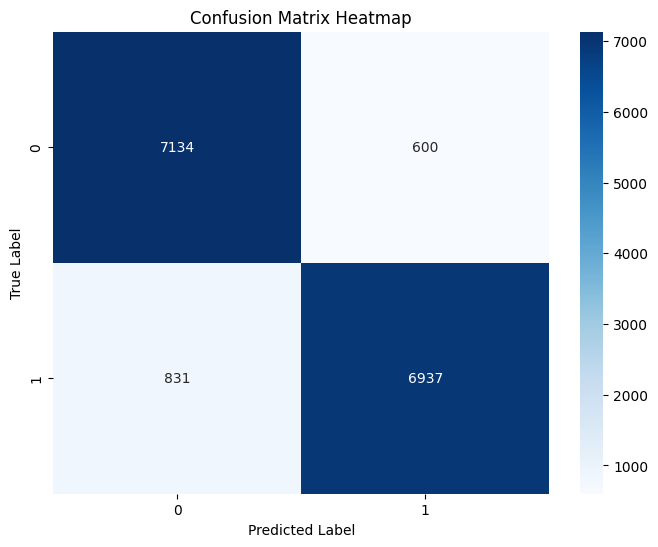

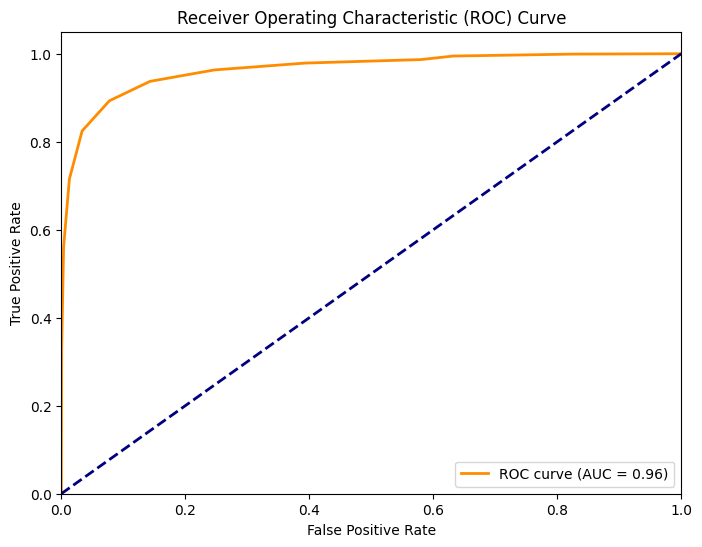

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
import plotly.express as px
from sklearn.decomposition import PCA

# Confusion Matrix Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix Heatmap')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


proba = rfc.predict_proba(X_test_scaled)
confidence_scores = np.max(proba, axis=1)


# ROC Curve
from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(y_test, proba[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2,
         label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
def compare_normal_vs_theft_highlights(data, y_pred, normal_idx, theft_idx, zoom_start, zoom_end):
    # extract time series for the selected customers and time range
    normal_series = data.iloc[normal_idx, 2:].loc[zoom_start:zoom_end]
    theft_series = data.iloc[theft_idx, 2:].loc[zoom_start:zoom_end]
    dates = normal_series.index

    # define thresholds for high peaks and low troughs (to highlight them)
    high_threshold = theft_series.quantile(0.95)  # top 5%
    low_threshold = theft_series.quantile(0.05)   # bottom 5%


    fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

    # the normal customer
    axes[0].plot(dates, normal_series, color="green", label="Normal Consumption")
    axes[0].set_title(f"Normal Customer ({data.iloc[normal_idx]['CONS_NO']})")
    axes[0].set_xlabel("Date")
    axes[0].set_ylabel("Consumption Value")
    axes[0].tick_params(axis="x", rotation=45)
    axes[0].legend()

    # the theft customer
    axes[1].plot(dates, theft_series, color="black", label="Theft Consumption")

    # higlight theft customer high peaks and low troughs
    if y_pred[theft_idx] == 1:
        high_anomalies = theft_series[theft_series > high_threshold]
        low_anomalies = theft_series[theft_series < low_threshold]


        axes[1].scatter(
            high_anomalies.index,
            high_anomalies.values,
            color="blue",
            label="Anomalous Behavior (peaks)",
            zorder=5,
        )

        axes[1].scatter(
            low_anomalies.index,
            low_anomalies.values,
            color="orange",
            label="Anomalous Behavior (troughs)",
            zorder=5,
        )

    axes[1].set_title(f"Theft Customer ({data.iloc[theft_idx]['CONS_NO']})")
    axes[1].set_xlabel("Date")
    axes[1].tick_params(axis="x", rotation=45)
    axes[1].legend()

    plt.tight_layout()
    plt.show()

In [ ]:
print(data.sample(10)[["CONS_NO", "FLAG"]])

                                CONS_NO  FLAG
15687  B89BA9DE004E0100FBA5679DFCEE056A     0
23212  6AF77A510887E8C73DFAF47BAA02D425     0
33028  C32C5D17AA6BE20320E2AE977971DD7A     0
19602  2596EDAE2A7695367E993F50BB3FE143     0
10690  949AA7FFBE6CF47629634D6FD0022C93     0
40316  48C946457DDF5291ED0BDC8D5064FB50     0
24414  C96CCC5890679A45DFF7C91B7559CF2E     0
23387  6A4682427B7D16A3B8CEAB7D107F336A     0
19757  024CFF6DB17F8DD76C7806EF9D971912     0
327    8E5473BBD2A0E6DC92785379D81ADEC8     1


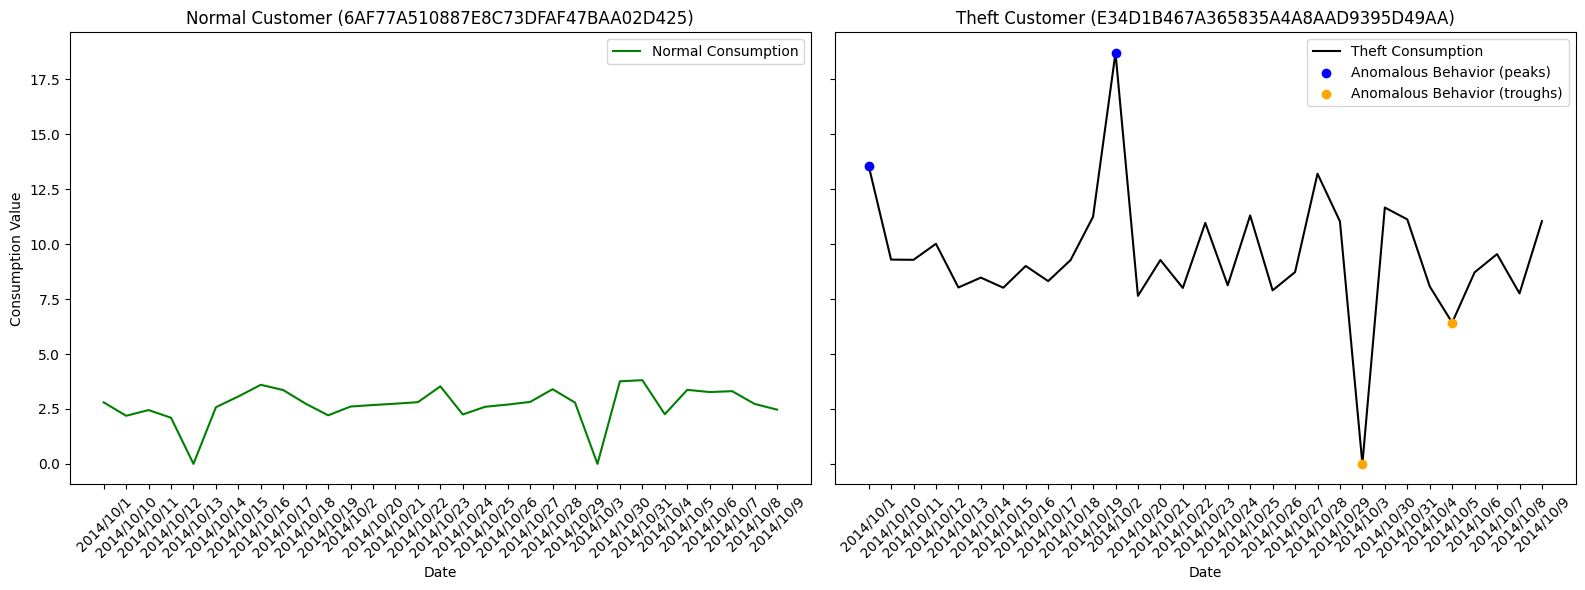

In [ ]:
compare_normal_vs_theft_highlights(
    data=data,
    y_pred=y_pred2,
    normal_idx=23212,                 # row index for a normal customer
    theft_idx=11,                  # row index for a theft customer
    zoom_start="2014/10/01",
    zoom_end="2014/11/01"
)
